## Inception with uncertainty

In [1]:
import pandas as pd
train_class = pd.read_csv('data/train_split_v4.csv', sep=' ')#, header=True)#, names=['patientID', 'image_path', 'class'])
test_class = pd.read_csv('data/test_split_v4.csv', sep=' ')#, header=True)#, names=['patientID', 'image_path', 'class'])

In [2]:
from codvidutils.utils import load_pictures
num_channels= 3
X_test = load_pictures(test_class,"data/test/",channels = num_channels)
X_train = load_pictures(train_class,"data/train/",channels = num_channels)

In [3]:
from codvidutils.imageproc import map_categorical
import numpy as np
values_dict = {'COVID-19': 1,'pneumonia': 2,'normal': 0}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
train_class['class_categorical'] = train_class['class'].apply(map_categorical, args=(values_dict,))
diseaseID_train = np.asarray(train_class["class_categorical"])
diseaseID_test  = np.asarray(test_class["class_categorical"])
print('shape X: {} {},  disease_ID (Y): {} {}'.format(X_train.shape[0], X_test.shape[0], diseaseID_train.shape[0], diseaseID_test.shape[0] ))

shape X: 13601 1541,  disease_ID (Y): 13601 1541


In [4]:
for i in range(40):
    #print(i)
    New_train = X_train[diseaseID_train==1][:187]
    #print(New_train.shape)
    #print(X_train.shape)
    new_Y = np.ones(New_train.shape[0])
    X_train = np.concatenate([X_train,New_train],axis=0)
    diseaseID_train = np.concatenate([diseaseID_train,new_Y],axis=0)


del New_train

In [5]:
from collections import Counter
counter = Counter (diseaseID_train)
print(counter)
dicto = {2:3500, 0: 3500, 1:6000}
print(dicto)

Counter({0.0: 7966, 1.0: 7667, 2.0: 5448})
{0: 3500, 1: 6000, 2: 3500}


In [6]:
from imblearn.under_sampling import RandomUnderSampler
#X = X.reshape(X,X.shape[0],-1)
X_train = X_train.reshape(X_train.shape[0],-1)
print(X_train.shape)
under = RandomUnderSampler(sampling_strategy =dicto)
X_train, diseaseID_train = under.fit_resample(X_train, diseaseID_train)
# summarize class distribution
print(diseaseID_train.shape)
print(X_train.shape)

(21081, 120000)
(13000,)
(13000, 120000)


In [7]:
print("Normal train: ",diseaseID_train[diseaseID_train==0].shape)
print("Pneumonia train: ",diseaseID_train[diseaseID_train==2].shape)
print("COVID train: ",diseaseID_train[diseaseID_train==1].shape)
print("*******************************************************")
print("Normal test: ",diseaseID_test[diseaseID_test==0].shape)
print("Pneumonia test: ",diseaseID_test[diseaseID_test==2].shape)
print("COVID test: ",diseaseID_test[diseaseID_test==1].shape)

Normal train:  (3500,)
Pneumonia train:  (3500,)
COVID train:  (6000,)
*******************************************************
Normal test:  (885,)
Pneumonia test:  (592,)
COVID test:  (64,)


In [8]:
Y_train = np.copy(diseaseID_train)
del diseaseID_train
Y_train[Y_train==2]=0
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0

In [9]:
def inception_block_R(previous_layer, p_drop,p_l2,filters =[32,64,16,16]):
    from tensorflow.keras.layers import concatenate,Dropout, Conv2D, MaxPooling2D #, Dropout
    from tensorflow.keras.regularizers import l2
    
    previous_drop = Dropout(rate = p_drop)(previous_layer, training=True)
    rama_1 = Conv2D(filters=filters[0], kernel_size=(1,1), activation='relu'
                            , bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(previous_drop)
    
    rama_2 = Conv2D(filters=filters[1], kernel_size=(1,1), activation='relu'
                            ,bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(previous_drop)
    rama_2 = Dropout(rate = p_drop)(rama_2, training=True)
    rama_2 = Conv2D(filters=filters[1], kernel_size=(3,3), activation='relu',padding="same"
                             ,bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(rama_2)
    
    rama_3 = Conv2D(filters=filters[2], kernel_size=(1,1), activation='relu'
                            ,bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(previous_drop)
    rama_3 = Dropout(rate = p_drop)(rama_3, training=True)
    rama_3 = Conv2D(filters=filters[2], kernel_size=(5,5), activation='relu',padding="same"
                            , bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(rama_3)
    
    rama_4 = MaxPooling2D(pool_size=(3,3),padding="same",strides=1)(previous_layer)
    rama_4 = Dropout(rate = p_drop)(rama_4, training=True)
    rama_4 = Conv2D(filters=filters[3], kernel_size=(1,1), activation='relu',padding="same"
                            ,bias_regularizer = l2(p_l2), kernel_regularizer=l2(p_l2))(rama_4)
    
    inception = concatenate([rama_1, rama_2,rama_3,rama_4])
    return inception

In [10]:
"""
Incep_6 archiquecture using Functional api
"""
def deep_inception_R(p_drop,p_l2):
    from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten, GlobalMaxPooling2D, Input,concatenate
    from tensorflow.keras.models import Model
   # from tensorflow.keras.regularizers import l2
    input_layer = Input(shape= (200,200,3,))
    #input_drop = Dropout(rate = p_drop)(input_layer)
    
    inception_1 = inception_block_R(input_layer,p_drop,p_l2)
    pool_1 = MaxPooling2D()(inception_1)
    
    inception_2 = inception_block_R(pool_1,p_drop,p_l2)
    pool_2 = MaxPooling2D()(inception_2)
    
    inception_3 = inception_block_R(pool_2,p_drop,p_l2)
    pool_3 = MaxPooling2D()(inception_3)
    
    inception_4 = inception_block_R(pool_3,p_drop,p_l2)
    pool_4 = MaxPooling2D()(inception_4)
    
    inception_5 = inception_block_R(pool_4,p_drop,p_l2,filters =[64,128,32,32])
    pool_5 = MaxPooling2D()(inception_5)
    
    inception_6 = inception_block_R(pool_5,p_drop,p_l2,filters =[64,128,32,32])
    
    gobal = GlobalMaxPooling2D()(inception_6)
    #gobal = Dropout(rate= p_drop)(gobal, training=True)
    
    dense = Dense(units=256,activation="relu")(gobal)
    #dense = Dropout(rate= p_drop)(dense, training=True)
    dense = Dense(units=64,activation="relu" )(dense)
    #dense = Dropout(rate= p_drop)(dense, training=True)
    out_layer= Dense(units =1, activation= "sigmoid")(dense)
    
    deep = Model(inputs=input_layer, outputs=out_layer)
    return deep


In [12]:
X_train = X_train.reshape([13000,200,200,3])
print('Train shape X: {},  Y: {} \n Test shape X: {}, Y: {}'.format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

Train shape X: (13000, 200, 200, 3),  Y: (13000,) 
 Test shape X: (1541, 200, 200, 3), Y: (1541,)


In [13]:
from codvidutils.utils import weigths2loss
dic_weights = weigths2loss(Y_train)
print(dic_weights)

{0: 0.46153846153846156, 1: 0.5384615384615384}


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
pdro = 0.08
pl2 = 0.000008

rescale_gen = ImageDataGenerator(rescale = 1./255,brightness_range=[0.85,1.0],rotation_range=10,zoom_range=[0.8,1.0])

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    filepath="Inception2uncer.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model = deep_inception_R(p_drop = pdro, p_l2 = pl2)

    ASG = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)

    model.compile(optimizer=ASG, loss='binary_crossentropy', metrics=['acc',"mse"])
    
    history = model.fit(rescale_gen.flow(X_train, Y_train, batch_size=32), epochs = 15, callbacks= [checkpoint],verbose=1, class_weight=dic_weights,validation_data=(X_test/255, Y_test))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 407 steps, validate on 1541 samples
Epoch 1/15
INFO:tensorflow:batch_all_reduce: 78 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:l

In [19]:
del X_train, Y_train
del strategy, rescale_gen
from tensorflow.keras.backend import clear_session
clear_session()

In [20]:
from tensorflow.keras.models import load_model
model = load_model("Inception2uncer.hdf5")

In [22]:
probs = []
T = 10
for _ in range(T):
    probs += [model.predict(X_test/255)]
    
predictive_mean = np.mean(probs, axis=0)
predictive_variance = np.var(probs, axis=0)

In [64]:
N = 13000
l = 1
tau = l**2 * (1 - pdro) / (2 * N * pl2)
print(tau)
print(1/tau)

4.423076923076923
0.22608695652173913


In [24]:
predictive_variance += tau**-1

## Uncertainty

In [25]:
Mean = predictive_mean 
Unce  = np.sqrt(predictive_variance)

In [55]:
print("******* MEAN values******")
cm = confusion_matrix(Y_test, Mean.round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)

******* MEAN values******
[[1449   28]
 [  43   21]] 
 [[0.98104265 0.01895735]
 [0.671875   0.328125  ]]


In [60]:
for p in Unce[diseaseID_test==0][:5]:
    print(p)

[0.47869712]
[0.48308644]
[0.47580096]
[0.47959316]
[0.47556263]


In [66]:
print(" Example values")
print("Normal people")
for p, u in zip(Mean[diseaseID_test==0][:5],Unce[diseaseID_test==0][:5]):
    print(p, "+/- ", u)
print("Neumonia")
for p, u in zip(Mean[diseaseID_test==2][:5],Unce[diseaseID_test==2][:5]):
    print(p, "+/- ", u)
print("COVID-19")
for p, u in zip(Mean[diseaseID_test==1][:5],Unce[diseaseID_test==1][:5]):
    print(p, "+/- ", u)

 Example values
Normal people
[0.15234318] +/-  [0.47869712]
[0.28352395] +/-  [0.48308644]
[0.02611563] +/-  [0.47580096]
[0.14515753] +/-  [0.47959316]
[0.02380938] +/-  [0.47556263]
Neumonia
[0.27865797] +/-  [0.4808758]
[0.09517097] +/-  [0.4770221]
[0.03706056] +/-  [0.47566187]
[0.11785085] +/-  [0.4782406]
[0.09705655] +/-  [0.4767759]
COVID-19
[0.5103244] +/-  [0.4841839]
[0.43107623] +/-  [0.4892768]
[0.48084053] +/-  [0.48171106]
[0.4798724] +/-  [0.48269764]
[0.3390975] +/-  [0.48192418]


In [28]:
def integraciones(integ, intervalos,A, B):
    from scipy.integrate import quad
    from numpy import inf
    intervalos[intervalos==0], intervalos[intervalos==1] =-inf, inf
    
    proba = np.ones([1,len(intervalos)-1])
    for j in range(len(A)):
        probabilidad = []
        for it in range(len(intervalos)-1):

            I = quad(integ,intervalos[it], intervalos[it+1], args = (A[j], B[j]) )
            probabilidad += [I]

        probabilidad = np.array(probabilidad)[:,0]
        probabilidad = probabilidad.reshape([1,len(intervalos)-1])

        proba = np.concatenate([proba,probabilidad],axis=0)
    return proba[1:]

In [30]:
dic_cuentas = {0: [], 1:[] }
dic_dest = {0: [], 1:[] }
intervalos = np.linspace(0,1, num = 38)
A = Mean[Y_test==0]
B = Unce[Y_test==0]
print(len(A),len(B))
prob = integraciones(integ,intervalos,A,B)
cuentas = np.nansum(prob,axis=0)
varianza = np.nansum((1-prob)*prob,axis=0)
dic_cuentas[0] = cuentas
dic_dest[0] = np.sqrt(varianza)
A = Mean[Y_test==1]
B = Unce[Y_test==1]
print(len(A),len(B))
prob = integraciones(integ,intervalos,A,B)
cuentas = np.nansum(prob,axis=0)
varianza = np.nansum((1-prob)*prob,axis=0)
dic_cuentas[1] = cuentas
dic_dest[1] = np.sqrt(varianza)

1477 1477
64 64


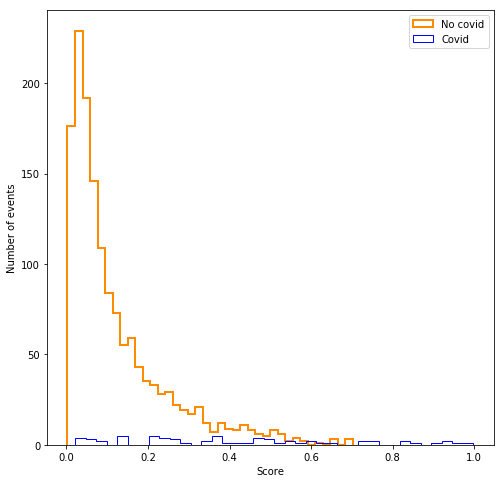

In [34]:
import matplotlib.pyplot as plt
pred = model.predict(X_test)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
plt.style.use('seaborn-deep')
plt.hist(Mean[(Y_test==0)],38,histtype='step',color='darkorange',lw=2,label= "No covid" )
plt.hist(Mean[Y_test==1],38,histtype='step',color='blue',lw=1 ,label="Covid")
plt.ylabel('Number of events')
plt.xlabel('Score')
plt.legend(loc="upper right")
plt.show()
#plt.savefig(filename)

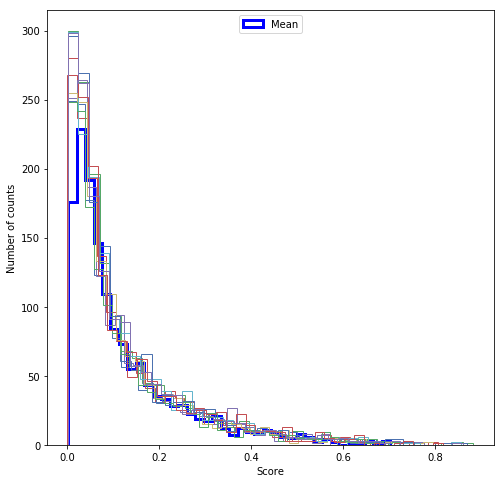

In [46]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6
#intervalos=intervalos[:-1]
#intervalos += intervalos[1]/2
plt.style.use('seaborn-deep')
plt.hist(Mean[Y_test==0],38,histtype='step',color='blue',lw=3 ,label="Mean")
for pr in probs:
    plt.hist(pr[(Y_test==0)],38,histtype='step',lw=1)


plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.legend(loc="upper center")
#plt.savefig(filename)

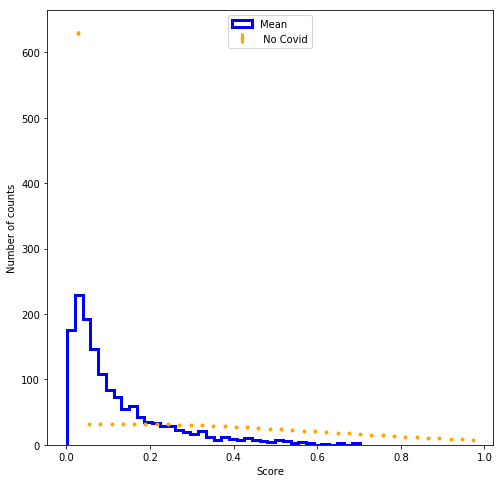

In [67]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6

plt.style.use('seaborn-deep')
plt.hist(Mean[Y_test==0],38,histtype='step',color='blue',lw=3 ,label="Mean")
plt.errorbar(intervalos[1:], dic_cuentas[0] ,fmt=" ",marker='.', yerr=dic_dest[1],lw=3, color="orange",label =" No Covid")

plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.legend(loc="upper center")
#plt.savefig(filename)

In [53]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Mean)
fpr_U, tpr_U, thr = roc_curve(Y_test,Mean+Unce)
fpr_L, tpr_L, thr = roc_curve(Y_test,Mean-Unce)
roc_auc = auc(fpr,tpr)
roc_auc_U = auc(fpr_U,tpr_U)
roc_auc_L = auc(fpr_L,tpr_L)

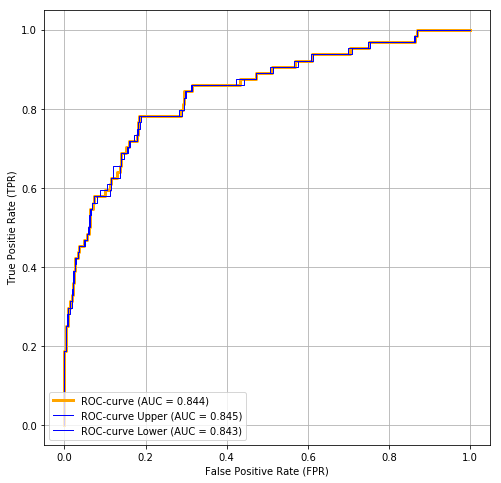

In [54]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
#plt.title("Simulation", weight="bold", x=0.50)
plt.grid(True)
#yticks(np.arange(0.97, 1, step=0.005))
lw = 2
plt.plot(fpr, tpr, color='orange',lw=3, label='ROC-curve (AUC = %0.3f)' % (roc_auc))
plt.plot(fpr_U, tpr_U, color='blue',lw=1, label='ROC-curve Upper (AUC = %0.3f)' % (roc_auc_U))
plt.plot(fpr_L, tpr_L, color='blue',lw=1, label='ROC-curve Lower (AUC = %0.3f)' % (roc_auc_L))



plt.ylabel('True Positie Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

#plt.title("Simulation Preliminary", color = '#e159e1',loc="left", weight="bold", size="large")
plt.legend(loc="lower left")
plt.show()